In [159]:
import sqlite3 as db
import pandas as pd
import seaborn as sns
import numpy as np
import sys
from fuzzywuzzy import fuzz
import pandasql as ps
from matplotlib import pyplot as plt

In [3]:
# Set the numpy to show the full list of an array
np.set_printoptions(threshold=sys.maxsize) # to show the full list of array

In [4]:
# Connect to database or create if doesn't exist
'''
Define the connection to the filepath of the file
'''
conn = db.connect('olist.db')

In [5]:
# Perform SQL query and return pandas data frame
df_geolocation = pd.read_sql_query (
"""
SELECT * 
FROM olist_geolocation_dataset;
""" ,conn)

df_order_customer = pd.read_sql_query (
"""
SELECT * 
FROM olist_order_customer_dataset;
""" ,conn)

df_order = pd.read_sql_query (
"""
SELECT * 
FROM olist_order_dataset;
""" ,conn)

df_order_items = pd.read_sql_query (
"""
SELECT * 
FROM olist_order_items_dataset;
""" ,conn)

df_order_payments = pd.read_sql_query (
"""
SELECT * 
FROM olist_order_payments_dataset;
""" ,conn)

df_order_reviews = pd.read_sql_query (
"""
SELECT * 
FROM olist_order_reviews_dataset;
""" ,conn)

df_products = pd.read_sql_query (
"""
SELECT * 
FROM olist_products_dataset;
""" ,conn)

df_sellers = pd.read_sql_query (
"""
SELECT * 
FROM olist_sellers_dataset;
""" ,conn)

df_product_cat_name_transl = pd.read_sql_query (
"""
SELECT * 
FROM product_category_name_translation;
""" ,conn)

In [6]:
df_product_cat_name_transl.head()

,index,product_category_name,product_category_name_english
0,0,beleza_saude,health_beauty
1,1,informatica_acessorios,computers_accessories
2,2,automotivo,auto
3,3,cama_mesa_banho,bed_bath_table
4,4,moveis_decoracao,furniture_decor


# 1. Handling Mismatched Datetime Data Type

## 1.A. Identifying the mismatch

In [7]:
df_geolocation.dtypes # all good

index                            int64
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

In [8]:
df_order_customer.dtypes # all good

index                        int64
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [9]:
df_order.dtypes # several variables' data type need to be changed 

index                             int64
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [10]:
df_order_items.dtypes # shipping_limit_date data type need to be changed

index                    int64
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [11]:
df_order_payments.dtypes # all good

index                     int64
order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object

In [12]:
df_order_reviews.dtypes # date related variables need to be changed to date

index                       int64
review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [13]:
df_products.dtypes # all good

index                           int64
product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

In [14]:
df_sellers.dtypes # all good

index                      int64
seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object

In [15]:
df_product_cat_name_transl.dtypes # all good

index                             int64
product_category_name            object
product_category_name_english    object
dtype: object

#### Key Highlight(s):
1. The dataframes that need to be handled are:
   1. df_order
   2. df_order_items
   3. df_order_reviews

## 1.B. Handling the data type mismatch

In [16]:
# On df_order
# Change the data type from str to datetime
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
df_order['order_approved_at'] = pd.to_datetime(df_order['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
df_order['order_delivered_carrier_date'] = pd.to_datetime(df_order['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
df_order['order_delivered_customer_date'] = pd.to_datetime(df_order['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
df_order['order_estimated_delivery_date'] = pd.to_datetime(df_order['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

In [17]:
# On df_order_items
# Change the data type from str to datetime
df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'], format='%Y-%m-%d %H:%M:%S')

In [18]:
# On df_order_reviews
# Change the data type from str to datetime
df_order_reviews['review_creation_date'] = pd.to_datetime(df_order_reviews['review_creation_date'], format='%Y-%m-%d %H:%M:%S')
df_order_reviews['review_answer_timestamp'] = pd.to_datetime(df_order_reviews['review_answer_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [19]:
# Check the altered data type
df_order.dtypes

index                                     int64
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

# 2. Handling Missing Values

## 2.A. Identifying missing values of each dataframe

In [20]:
# Summarry of Missing Values in df_geolocation
df_geolocation.isna().sum()/len(df_geolocation)*100

index                          0.0
geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

In [21]:
# Summarry of Missing Values in df_order_customer
df_order_customer.isna().sum()/len(df_order_customer)*100

index                       0.0
customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64

In [22]:
# Summarry of Missing Values in df_order
df_order.isna().sum()/len(df_order)*100

index                            0.000000
order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

In [23]:
# Summarry of Missing Values in df_order_items
df_order_items.isna().sum()/len(df_order_items)*100

index                  0.0
order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

In [24]:
# Summarry of Missing Values in df_order_payments
df_order_payments.isna().sum()/len(df_order_payments)*100


index                   0.0
order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64

In [25]:
# Summarry of Missing Values in df_order_reviews
df_order_reviews.isna().sum()/len(df_order_reviews)*100

index                       0.000000
review_id                   0.000000
order_id                    0.000000
review_score                0.000000
review_comment_title       88.341530
review_comment_message     58.702532
review_creation_date        0.000000
review_answer_timestamp     0.000000
dtype: float64

In [26]:
# Summarry of Missing Values in df_products
df_products.isna().sum()/len(df_products)*100

index                         0.000000
product_id                    0.000000
product_category_name         1.851234
product_name_lenght           1.851234
product_description_lenght    1.851234
product_photos_qty            1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
dtype: float64

In [27]:
# Summarry of Missing Values in df_sellers
df_sellers.isna().sum()/len(df_sellers)*100

index                     0.0
seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64

In [28]:
# Summarry of Missing Values in df_product_cat_name_transl
df_product_cat_name_transl.isna().sum()/len(df_product_cat_name_transl)*100

index                            0.0
product_category_name            0.0
product_category_name_english    0.0
dtype: float64

#### Key Highlight(s):
1. The dataframes that need to be handled are:
   1. df_order
   2. df_order_reviews
   3. df_products

## 2.B. Handling missing values according to each condition

In [29]:
# On df_order
# Fill the missing value using backward fill (next observation carried backward:)
# Assuming that the dates carried backward could estimate the actual date 
df_order["order_approved_at"] = df_order["order_approved_at"].bfill()
df_order["order_delivered_carrier_date"] = df_order["order_delivered_carrier_date"].bfill()
df_order["order_delivered_customer_date"] = df_order["order_delivered_customer_date"].bfill()

# Check the current condition
df_order.isna().sum()/len(df_order)*100

index                            0.0
order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
dtype: float64

In [30]:
# On df_order_reviews
# The column with missing values are dropped
# The data is not used (mot running sentiment analysis)
df_order_reviews = df_order_reviews.drop(['review_comment_title', 'review_comment_message'], axis=1)

# Check the current condition
df_order_reviews.isna().sum()/len(df_order_reviews)*100

index                      0.0
review_id                  0.0
order_id                   0.0
review_score               0.0
review_creation_date       0.0
review_answer_timestamp    0.0
dtype: float64

In [31]:
# On df_products
# The missing values are filled accordingly
mod_product_category_name = df_products["product_category_name"].mode()[0] # get the mode
df_products["product_category_name"] = df_products["product_category_name"].fillna(mod_product_category_name) # fill w/ mode

med_product_name_lenght = df_products["product_name_lenght"].median() # get the median
df_products["product_name_lenght"] = df_products["product_name_lenght"].fillna(med_product_name_lenght) # fill w/ median

med_product_desc_lenght = df_products["product_description_lenght"].median() # get the median
df_products["product_description_lenght"] = df_products["product_description_lenght"].fillna(med_product_desc_lenght) # fill w/ median

med_photos_qty = df_products["product_photos_qty"].median() # get the median
df_products["product_photos_qty"] = df_products["product_photos_qty"].fillna(med_photos_qty) # fill w/ median

med_weight_g = df_products["product_weight_g"].median() # get the median
df_products["product_weight_g"] = df_products["product_weight_g"].fillna(med_weight_g) # fill w/ median

med_length_cm = df_products["product_length_cm"].median() # get the median
df_products["product_length_cm"] = df_products["product_length_cm"].fillna(med_length_cm) # fill w/ median

med_height_cm = df_products["product_height_cm"].median() # get the median
df_products["product_height_cm"] = df_products["product_height_cm"].fillna(med_height_cm) # fill w/ median

med_width_cm = df_products["product_width_cm"].median() # get the median
df_products["product_width_cm"] = df_products["product_width_cm"].fillna(med_width_cm) # fill w/ median

df_products.isna().sum()/len(df_products)*100

index                         0.0
product_id                    0.0
product_category_name         0.0
product_name_lenght           0.0
product_description_lenght    0.0
product_photos_qty            0.0
product_weight_g              0.0
product_length_cm             0.0
product_height_cm             0.0
product_width_cm              0.0
dtype: float64

# 3. Handling Outlier

## 3.A. Identifying outlier

In [32]:
# Indentify which data has outlier
df_order_payments.describe() # outlier identified in payment related variables (max value is way further away from Q3)

,index,payment_sequential,payment_installments,payment_value
count,103886.00000,103886.000000,103886.000000,103886.000000
mean,51942.50000,1.092679,2.853349,154.100380
std,29989.44937,0.706584,2.687051,217.494064
min,0.00000,1.000000,0.000000,0.000000
25%,25971.25000,1.000000,1.000000,56.790000
50%,51942.50000,1.000000,1.000000,100.000000
75%,77913.75000,1.000000,4.000000,171.837500
max,103885.00000,29.000000,24.000000,13664.080000


### 3.A.1. Identifying outlier: payment_sequential

<Axes: xlabel='payment_sequential', ylabel='Count'>

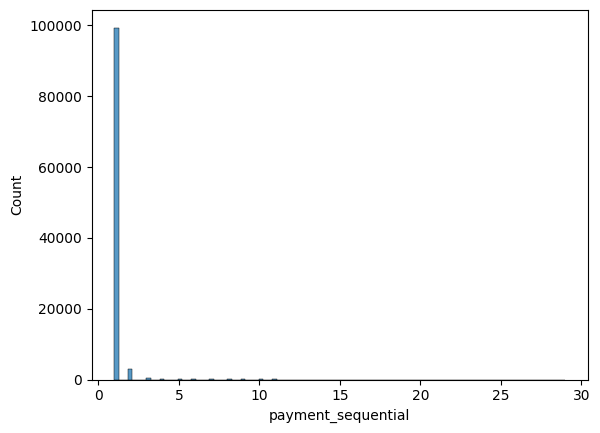

In [33]:
# Draw a plot of payment_sequential
sns.histplot(df_order_payments, x="payment_sequential", bins=100) # based on this histogram, there're outliers in payment_sequential

<Axes: xlabel='payment_sequential'>

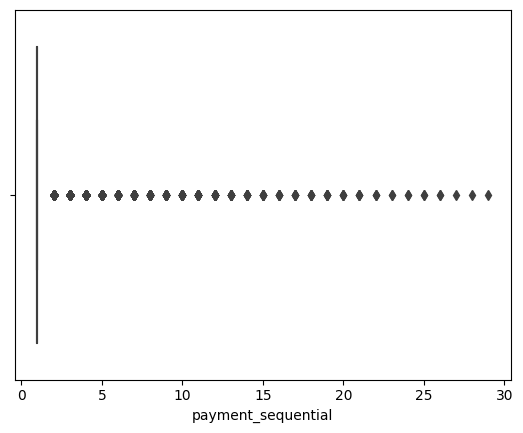

In [34]:
# Double check using boxplot
sns.boxplot(x=df_order_payments['payment_sequential'])

### 3.A.2. Identifying outlier: payment_installments

<Axes: xlabel='payment_installments', ylabel='Count'>

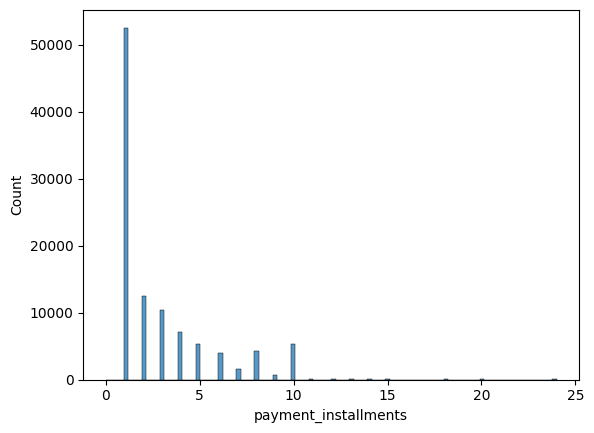

In [35]:
# Draw a plot of payment_installments
sns.histplot(df_order_payments, x="payment_installments", bins=100) # based on this histogram, there're outliers in payment_installments

<Axes: xlabel='payment_installments'>

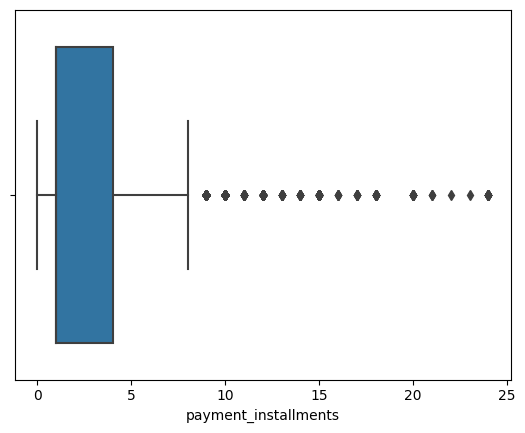

In [36]:
# Double check using boxplot
sns.boxplot(x=df_order_payments['payment_installments'])


### 3.A.3. Identifying outlier: payment_value

<Axes: xlabel='payment_value', ylabel='Count'>

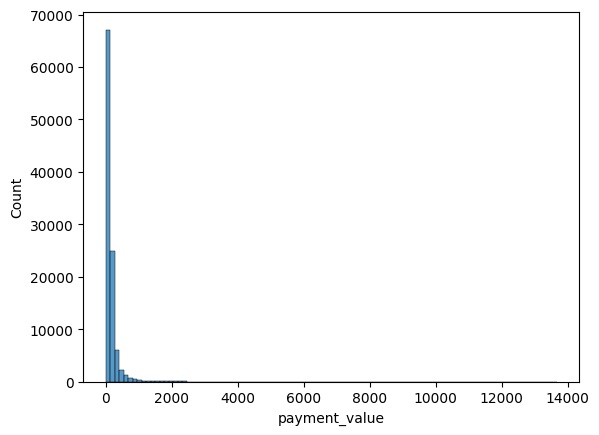

In [37]:
sns.histplot(df_order_payments, x="payment_value", bins=100) # based on this histogram, there's outlier in payment_value

<Axes: xlabel='payment_value'>

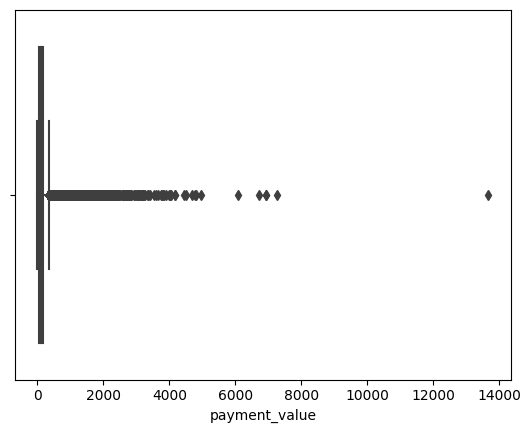

In [38]:
# Double check using boxplot
sns.boxplot(x=df_order_payments['payment_value'])

## 3.B. Handling identified outlier

### 3.B.A. Handling outliers: payment_sequential

<Axes: xlabel='payment_sequential', ylabel='Count'>

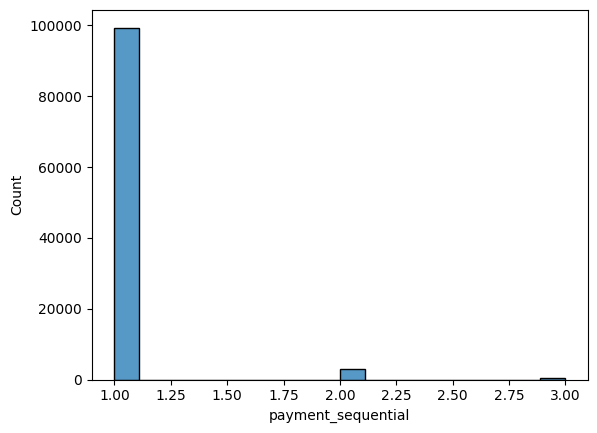

In [39]:
# CHECK HOW THE DATA LOOKS WITH ITS OULIERS DELETED
# Define upper bound
upper_bound = df_order_payments["payment_sequential"].median() + df_order_payments["payment_sequential"].std()*3 # median is used because data is skewed

# Define df without outlier
df_order_payments_without_outlier = df_order_payments[df_order_payments["payment_sequential"] <= upper_bound]

# Plot to see the distribution without outlier
sns.histplot(df_order_payments_without_outlier, x='payment_sequential')

In [40]:
# Find the median of payment_sequential
med_payment_sequential = df_order_payments['payment_sequential'].median()

# Replace the outlier with the median
df_order_payments.loc[df_order_payments['payment_sequential'] > upper_bound, "payment_sequential"] = med_payment_sequential

# Check the change (see the max sequential of payment_sequential)
df_order_payments.describe()

,index,payment_sequential,payment_installments,payment_value
count,103886.00000,103886.000000,103886.000000,103886.000000
mean,51942.50000,1.040439,2.853349,154.100380
std,29989.44937,0.223582,2.687051,217.494064
min,0.00000,1.000000,0.000000,0.000000
25%,25971.25000,1.000000,1.000000,56.790000
50%,51942.50000,1.000000,1.000000,100.000000
75%,77913.75000,1.000000,4.000000,171.837500
max,103885.00000,3.000000,24.000000,13664.080000


<Axes: xlabel='payment_sequential', ylabel='Count'>

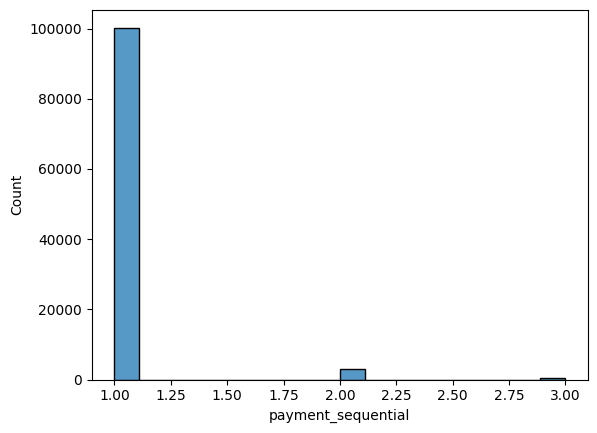

In [41]:
# Plot to see the distribution with outliers changed to its median
sns.histplot(df_order_payments, x='payment_sequential')

### 3.B.B. Handling outliers: payment_installments

<Axes: xlabel='payment_installments', ylabel='Count'>

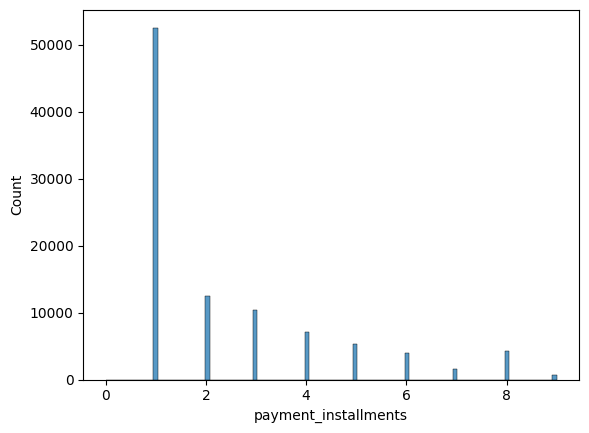

In [42]:
# CHECK HOW THE DATA LOOKS WITH ITS OULIERS DELETED
# Define upper bound
upper_bound = df_order_payments["payment_installments"].median() + df_order_payments["payment_installments"].std()*3 # median is used because data is skewed

# Define df without outlier
df_order_payments_without_outlier = df_order_payments[df_order_payments["payment_installments"] <= upper_bound]

# Plot to see the distribution without outlier
sns.histplot(df_order_payments_without_outlier, x='payment_installments')

In [43]:
# REPLACING OUTLIERS WITH MEDIAN VALUE
# Find the median of payment_installments
med_payment_installments = df_order_payments['payment_installments'].median()

# Replace the outlier with the median
df_order_payments.loc[df_order_payments['payment_installments'] > upper_bound, "payment_installments"] = med_payment_installments

# Check the change (see the max sequential of payment_installments)
df_order_payments.describe()

,index,payment_sequential,payment_installments,payment_value
count,103886.00000,103886.000000,103886.000000,103886.000000
mean,51942.50000,1.040439,2.347313,154.100380
std,29989.44937,0.223582,2.011350,217.494064
min,0.00000,1.000000,0.000000,0.000000
25%,25971.25000,1.000000,1.000000,56.790000
50%,51942.50000,1.000000,1.000000,100.000000
75%,77913.75000,1.000000,3.000000,171.837500
max,103885.00000,3.000000,9.000000,13664.080000


<Axes: xlabel='payment_installments', ylabel='Count'>

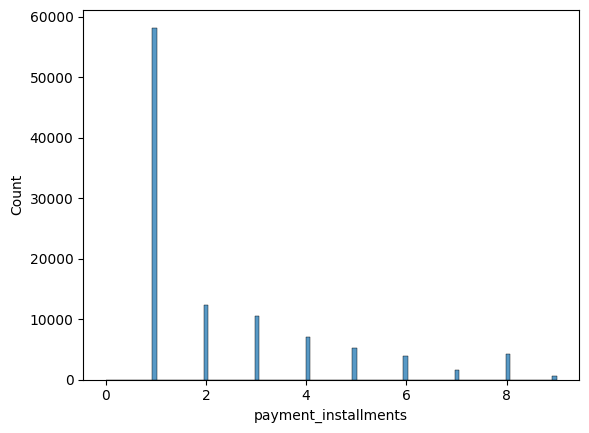

In [44]:
# Plot to see the distribution with outliers changed to its median
sns.histplot(df_order_payments, x='payment_installments')

### 3.B.C. Handling outliers: payment_value

<Axes: xlabel='payment_value', ylabel='Count'>

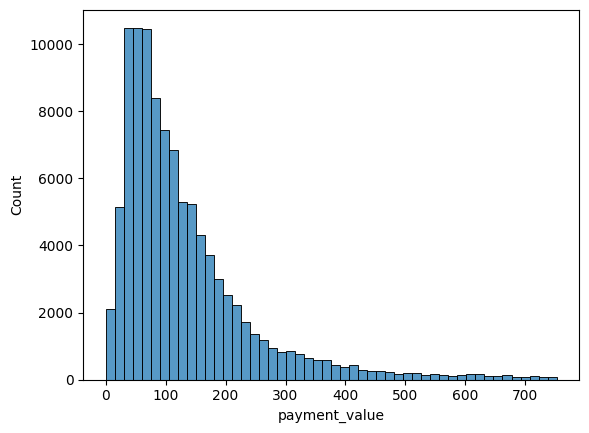

In [45]:
# CHECK HOW THE DATA LOOKS WITH ITS OULIERS DELETED
# Define upper bound
upper_bound = df_order_payments["payment_value"].median() + df_order_payments["payment_value"].std()*3 # median is used because data is skewed

# Define df without outlier
df_order_payments_without_outlier = df_order_payments[df_order_payments["payment_value"] <= upper_bound]

# Plot to see the distribution without outlier
sns.histplot(df_order_payments_without_outlier, x='payment_value', bins=50)

In [46]:
# REPLACING OUTLIERS WITH MEDIAN VALUE
# Find the median of payment_value
med_payment_value = df_order_payments['payment_value'].median()

# Replace the outlier with the median
df_order_payments.loc[df_order_payments['payment_value'] > upper_bound, "payment_value"] = med_payment_value

# Check the change (see the max value of payment_value)
df_order_payments.describe()

,index,payment_sequential,payment_installments,payment_value
count,103886.00000,103886.000000,103886.000000,103886.000000
mean,51942.50000,1.040439,2.347313,131.085589
std,29989.44937,0.223582,2.011350,114.253445
min,0.00000,1.000000,0.000000,0.000000
25%,25971.25000,1.000000,1.000000,56.790000
50%,51942.50000,1.000000,1.000000,100.000000
75%,77913.75000,1.000000,3.000000,164.240000
max,103885.00000,3.000000,9.000000,752.210000


<Axes: xlabel='payment_value', ylabel='Count'>

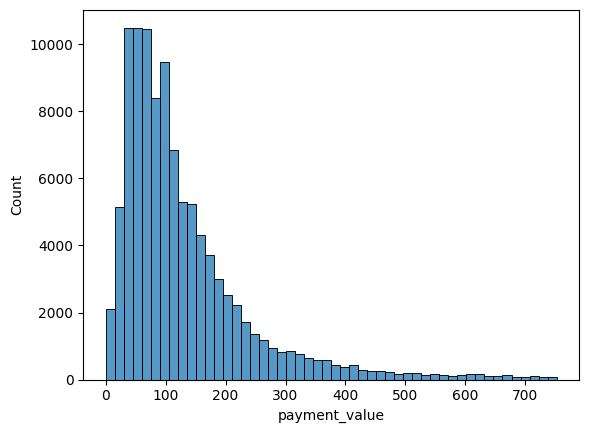

In [47]:
# Plot to see the distribution with the outlier changed to median
sns.histplot(df_order_payments, x='payment_value', bins=50)

# 4. Handling Duplicates

In [48]:
# Check whether duplicate exist
df_geolocation.duplicated(keep=False).describe()

count     1000163
unique          1
top         False
freq      1000163
dtype: object

In [49]:
# Check whether duplicate exist
df_order_customer['customer_id'].duplicated(keep=False).describe()


count     99441
unique        1
top       False
freq      99441
Name: customer_id, dtype: object

In [50]:
# Check whether duplicate exist
df_order.duplicated(keep=False).describe()

count     99441
unique        1
top       False
freq      99441
dtype: object

In [51]:
# Check whether duplicate exist
df_order['order_purchase_timestamp'].sort_values().value_counts()

order_purchase_timestamp
2018-06-01 13:39:44    3
2018-07-28 13:11:22    3
2018-04-11 10:48:14    3
2018-08-02 12:06:09    3
2018-08-02 12:06:07    3
                      ..
2017-11-07 22:02:05    1
2017-11-07 21:58:38    1
2017-11-07 21:57:26    1
2017-11-07 21:50:08    1
2018-10-17 17:30:18    1
Name: count, Length: 98875, dtype: int64

In [52]:
# Check whether duplicate exist
df_order_items.duplicated(keep=False).describe()

count     112650
unique         1
top        False
freq      112650
dtype: object

In [53]:
# Check whether duplicate exist
df_order_payments.duplicated(keep=False).describe()

count     103886
unique         1
top        False
freq      103886
dtype: object

In [54]:
# Check whether duplicate exist
df_order_reviews.duplicated(keep=False).describe()

count     99224
unique        1
top       False
freq      99224
dtype: object

In [55]:
# Check whether duplicate exist
df_products.duplicated(keep=False).describe()

count     32951
unique        1
top       False
freq      32951
dtype: object

In [56]:
# Check whether duplicate exist
df_sellers.duplicated(keep=False).describe()

count      3095
unique        1
top       False
freq       3095
dtype: object

In [57]:
# Check whether duplicate exist
df_product_cat_name_transl.duplicated(keep=False).describe()

count        71
unique        1
top       False
freq         71
dtype: object

### Key insight(s):
1. There is no duplicate in all the data tables.

# 5. Handling Format Inconsistencies/Typos

## 5.A. Identify variables prone to typo

In [58]:
# Identify potential inconsistencies
df_geolocation['geolocation_city'].value_counts()
df_order_customer['customer_city'].value_counts()
df_sellers['seller_city'].value_counts()

# City name tend to have typos

seller_city
sao paulo              694
curitiba               127
rio de janeiro          96
belo horizonte          68
ribeirao preto          52
                      ... 
taruma                   1
s jose do rio preto      1
domingos martins         1
messias targino          1
leme                     1
Name: count, Length: 611, dtype: int64

In [59]:
df_geolocation['geolocation_city'].unique()

array(['sao paulo', 'são paulo', 'sao bernardo do campo', 'jundiaí',
       'taboão da serra', 'sãopaulo', 'sp', 'sa£o paulo',
       'sao jose dos campos', 'osasco', 'carapicuíba', 'carapicuiba',
       'barueri', 'santana de parnaiba', 'pirapora do bom jesus',
       'santana de parnaíba', 'jandira', 'itapevi', 'cotia',
       'taboao da serra', 'vargem grande paulista', 'embu das artes',
       'itapecerica da serra', 'embu', 'são lourenço da serra',
       'sao lourenco da serra', 'embu-guacu', 'embu-guaçu', 'embu guaçu',
       'juquitiba', 'embu guacu', 'embuguacu', 'guarulhos', 'adamantina',
       'guarulhos-sp', 'aruja', 'arujá', 'santa isabel', 'mairipora',
       'mairiporã', 'cajamar', 'caieiras', 'jordanesia', 'polvilho',
       'mauá', 'jordanésia', 'franco da rocha', 'francisco morato', 'poa',
       'itaquaquecetuba', 'ferraz de vasconcelos', 'poá', 'suzano',
       'mogi das cruzes', 'mogidascruzes', 'salesopolis',
       'biritiba-mirim', 'guararema', 'salesópolis', '

## 5.B. Handling Inconsistencies

In [60]:
dict_chara_replace = {
    "ã" : "a",
    "á" : "a",
    "â" : "a",
    "ç" : "c",
    "é" : "e",
    "ê" : "e",
    "í" : "i",
    "ó" : "o",
    "ú" : "u",
    "'" : " ",
    "£" : "",
    "ô" :"o",
    "õ" : "o",
    "-" : " ",
    "  " : " "
}

In [61]:
# Create a function to standardize the characters
def standardize_chara(data, col_name):
    data[col_name] = data[col_name].str.lower()

    for chara in dict_chara_replace:
       data[col_name] = data[col_name].str.replace(chara, dict_chara_replace[chara])

In [62]:
map_city_names = {
    "saopaulo" : "sao paulo",
    "sp" : "sau paulo",
    "sao paulo / sao paulo" : "sao paulo",
    "sao paulo sp" : "sao paulo",
    "sao paulo  sp" : "sao paulo",
    "santo andre/sao paulo" : "santo andre",
    "maua/sao paulo" : "maua",
    "ribeirao preto / sao paulo" : "riberiao preto",
    "carapicuiba / sao paulo" : "carapicuiba",
    "carapicuiba / sao paulo" : "carapicuiba",
    "sao paulop" : "sao paulo",
    "jacarei / sao paulo" : "jacarei",
    "guarulhos-sp" : "guarulhos",
    "pariquera acu" : "pariquera-acu",
    "vitorinos - alto rio doce" : "virotinos",
    "vitorinos - alto rio doce" : "virotinos",
    "praia grande (fundao)" : "praia grande",
    "tamoios (cabo frio)": "tamoios",
    "antunes (igaratinga)" : "antunes",
    "monte gordo (camacari)  distrito" : "monte gordo",
    "jacare (cabreuva)" : "jacare",
    "california da barra (barra do pirai)" : "california da barra",
    "penedo (itatiaia)" : "penedo",
    "bacaxa (saquarema)  distrito" : "bacaxa",
    "praia grande (fundao)  distrito" : "praia grande",
    "itabatan (mucuri)" : "itabatan",
    "realeza (manhuacu)" : "realeza",
    "mogi-guacu" : "mogi guacu",
    "biritiba-mirim" : "biritiba mirim",
    "mogi-mirim" : "mogi mirim",
    "venda nova do imigrante-es" : "venda nova do imigrante",
    "pariquera-acu" : "pariquera acu",
    "varre-sai" : "varre sai",
    "naque-nanuque" : "naque nanuque",
    "embu-guacu" : "embu guacu",
    "pingo-dagua" : "pingo d agua",
    "pingo d agua" : "pingo d agua",
    "pariquera-acu" : "pariquera acu",
    "olhos dagua" : "olhos d agua",
    "olho dagua das cunhas" : "olho d agua das cunhas",
    "olho dagua grande" : "olho d agua grande",
    "s jose do rio preto" : "sao jose do rio preto"   
}

In [63]:
# On df_geolocation
# Standardize the characters
standardize_chara(df_geolocation, 'geolocation_city')

# Replace the inconsistencies of city names
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].replace(map_city_names)
df_geolocation['geolocation_city'].value_counts()

geolocation_city
sao paulo               160721
rio de janeiro           62151
belo horizonte           27805
curitiba                 16593
porto alegre             13521
                         ...  
ceilandia norte              1
azambuja                     1
algodao de jandaira          1
ipuca                        1
alta floresta doeste         1
Name: count, Length: 5924, dtype: int64

In [64]:
# On df_order_customer
# Standardize the characters
standardize_chara(df_order_customer, 'customer_city')

# Replace the inconsistencies of city names
df_order_customer['customer_city'] = df_order_customer['customer_city'].replace(map_city_names)
df_order_customer['customer_city'].value_counts()

customer_city
sao paulo               15540
rio de janeiro           6882
belo horizonte           2773
brasilia                 2131
curitiba                 1521
                        ...  
central                     1
nova independencia          1
cha de alegria              1
sao joao do itaperiu        1
eugenio de castro           1
Name: count, Length: 4113, dtype: int64

In [65]:
# On df_sellers
# Standardize the characters
standardize_chara(df_sellers, 'seller_city')

# Replace the inconsistencies of city names
df_sellers['seller_city'] = df_sellers['seller_city'].replace(map_city_names)
df_sellers['seller_city'].value_counts()

seller_city
sao paulo         701
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
                 ... 
lagoa santa         1
nhandeara           1
guarapuava          1
sinop               1
leme                1
Name: count, Length: 598, dtype: int64

In [66]:
# Check the city names
df_geolocation['geolocation_city'].unique()
df_order_customer['customer_city'].unique()
df_sellers['seller_city'].unique()

array(['campinas', 'mogi guacu', 'rio de janeiro', 'sao paulo',
       'braganca paulista', 'brejao', 'penapolis', 'curitiba', 'anapolis',
       'itirapina', 'tubarao', 'lauro de freitas', 'imbituba', 'brasilia',
       'porto seguro', 'guaruja', 'tabatinga', 'salto', 'tres de maio',
       'belo horizonte', 'arapongas', 'sao bernardo do campo', 'tatui',
       'garopaba', 'camanducaia', 'tupa', 'guarulhos',
       'sao jose dos pinhais', 'sao ludgero', 'sao jose', 'piracicaba',
       'porto alegre', 'congonhal', 'santo andre', 'osasco', 'valinhos',
       'joinville', 'saquarema', 'barra velha', 'petropolis',
       'santo antonio da patrulha', 'ponta grossa', 'santana de parnaiba',
       'sao carlos', 'ibitinga', 'barueri', 'caxias do sul', 'araguari',
       'contagem', 'jaragua do sul', 'lages  sc', 'bento goncalves',
       'catanduva', 'ribeirao pires', 'jaboticabal', 'echapora', 'cotia',
       'rio do sul', 'sorocaba', 'pradopolis', 'itaborai', 'mirassol',
       'birigui', 

### OMITTED - This Correction Method is Too Time-Consuming (Not Performant Enough)

In [67]:
# # Read the csv file
# df_cities = pd.read_csv("cities.csv")

# # Drope the code column
# df_cities = df_cities.drop('code', axis=1) 

# # standardize the writing
# standardize_chara(df_cities, 'name')

# # Define a list out of city names
# city_names = df_cities['name'].to_list()
# city_names

In [68]:
# # Create a function to correct the typo w/ fuzzywuzzy
# def correct_typo(name, reference):
#     for correct_name in reference:
#         percent_match_to_correct = fuzz.ratio(correct_name, name)
#         if percent_match_to_correct > 80:
#             name = correct_name
#     return name

In [69]:
# # Test the function
# name_test_1 = 'sao pauli'

# name_res_1 = correct_typo(name_test_1, reference=city_names)
# name_res_1

In [70]:
# df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].apply(correct_typo, reference=city_names)

In [71]:
# df_geolocation.to_csv('df_geolocation_test.csv')

# 6. Analyzing Data

**Note:** I use pandasql lib to analyze the wrangled dataframes. One of the reasons is to hone my skill in using SQL while keeping my work in one workplace (this python notebook).

In [72]:
# Clean the extra index column and export to CSV
df_geolocation = df_geolocation.iloc[: , 1:] 
df_geolocation.to_csv("clean_dataset/df_geolocation.csv", index=False)

df_order_customer = df_order_customer.iloc[: , 1:]
df_order_customer.to_csv("clean_dataset/df_order_customer.csv", index=False)

df_order = df_order.iloc[: , 1:]
df_order.to_csv("clean_dataset/df_order.csv", index=False)

df_order_items = df_order_items.iloc[: , 1:]
df_order_items.to_csv("clean_dataset/df_order_items.csv", index=False)

df_order_payments = df_order_payments.iloc[: , 1:]
df_order_payments.to_csv("clean_dataset/df_order_payments.csv", index=False)

df_order_reviews = df_order_reviews.iloc[: , 1:]
df_order_reviews.to_csv("clean_dataset/df_order_reviews.csv", index=False)

df_products = df_products.iloc[: , 1:]
df_products.to_csv("clean_dataset/df_products.csv", index=False)

df_sellers = df_sellers.iloc[: , 1:]
df_sellers.to_csv("clean_dataset/df_sellers.csv", index=False)

df_product_cat_name_transl = df_product_cat_name_transl.iloc[: , 1:]
df_product_cat_name_transl.to_csv("clean_dataset/df_product_cat_name_transl.csv", index=False)

## 6.A. Platform's Monhtly GMV

**Gross Merchandise Value (GMV)** is the total value of merchandise sold over a given period of time through a customer-to-customer (C2C) exchange site. It is a measure of the growth of the business or use of the site to sell merchandise owned by others. 

In [73]:
# Find the monthly GMV
query_gmv = """
SELECT *
FROM
    (SELECT
        strftime('%Y-%m', o.order_purchase_timestamp) AS year_month,
        SUM(op.payment_value) AS transaction_value
    FROM 
        df_order AS o
    INNER JOIN
        df_order_payments AS op ON o.order_id = op.order_id
    GROUP BY 
        strftime('%Y-%m', o.order_purchase_timestamp)
    ORDER BY
        year_month DESC
    LIMIT 12
) AS ym
ORDER BY year_month ASC
"""


df_gmv = ps.sqldf(query_gmv, locals())
df_gmv

,year_month,transaction_value
0,2017-11,1041886.34
1,2017-12,784257.20
2,2018-01,981544.30
3,2018-02,894058.16
4,2018-03,1011297.90
5,2018-04,968799.30
6,2018-05,945897.24
7,2018-06,867827.90
8,2018-07,876985.23
9,2018-08,865993.94


<Axes: xlabel='year_month', ylabel='transaction_value'>

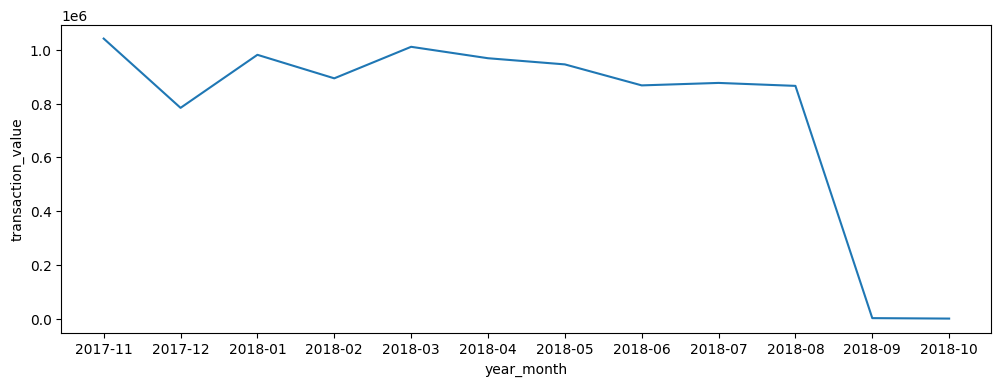

In [74]:
# Plot the monthly GMV as a line plot
a4_dims = (12, 4)
data = df_gmv
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax=ax, data=data, x="year_month", y="transaction_value")

**Key insight(s):**
1. The GMV is declining in the last 12 months
2. The is plummeting in Sept '18

## 6.B. Gross Merchandise Value based on Customer Location

In [75]:
# Query the table
query_trans_val_by_cust_loc = """
SELECT
    oc.customer_state AS cust_loc,
    SUM(op.payment_value) AS transaction_value
FROM
    df_order AS o
INNER JOIN
    df_order_payments AS op ON o.order_id = op.order_id
INNER JOIN
    df_order_customer AS oc ON o.customer_id = oc.customer_id

GROUP BY oc.customer_state
ORDER BY transaction_value DESC
LIMIT 10;
"""

# Define the query result as a dataframe
df_trans_val_by_cust_loc = ps.sqldf(query_trans_val_by_cust_loc, locals())
df_trans_val_by_cust_loc

,cust_loc,transaction_value
0,SP,5253566.55
1,RJ,1816757.54
2,MG,1603762.04
3,RS,771491.26
4,PR,680461.17
5,SC,515874.85
6,BA,502313.29
7,DF,297254.13
8,GO,293898.33
9,ES,281932.46


<Axes: xlabel='transaction_value', ylabel='cust_loc'>

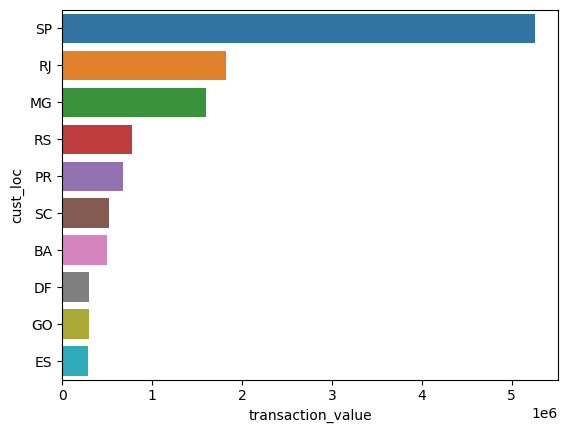

In [76]:
# Plot the query result
sns.barplot(data=df_trans_val_by_cust_loc, x="transaction_value", y="cust_loc")

## 6.C. Gross Merchandise Value based on Product Category

In [77]:
# Query the table
query_trans_val_by_cat = """
SELECT
    pcnt.product_category_name_english AS product_category,
    SUM(op.payment_value) AS transaction_value
FROM
    df_order AS o
INNER JOIN
    df_order_items AS oi ON o.order_id = oi.order_id
INNER JOIN
    df_products AS p ON oi.product_id = p.product_id
INNER JOIN
    df_product_cat_name_transl AS pcnt ON p.product_category_name = pcnt.product_category_name
INNER JOIN
    df_order_payments AS op ON o.order_id = op.order_id
GROUP BY product_category
ORDER BY transaction_value DESC
LIMIT 10;
"""

# Define the query result as a dataframe
df_trans_val_by_cat = ps.sqldf(query_trans_val_by_cat, locals())
df_trans_val_by_cat

,product_category,transaction_value
0,bed_bath_table,1823041.59
1,health_beauty,1426720.36
2,furniture_decor,1287402.02
3,sports_leisure,1238222.55
4,computers_accessories,1186148.41
5,watches_gifts,1122744.90
6,housewares,936748.52
7,cool_stuff,683318.12
8,garden_tools,682563.50
9,auto,641456.81


<Axes: xlabel='transaction_value', ylabel='product_category'>

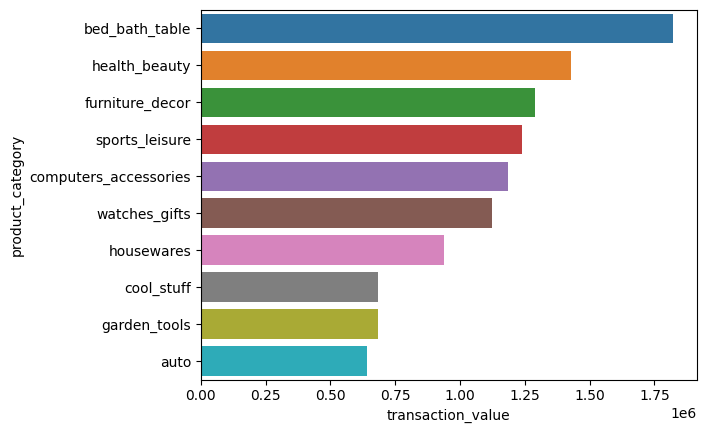

In [78]:
# Plot the query result
sns.barplot(data=df_trans_val_by_cat, x="transaction_value", y="product_category")

## 6.D. Favorite Day and Date to Do Shopping

### Favorite Date for Shopping

In [79]:
# Find the fav day
query_fav_date_to_shop = """
SELECT
    strftime('%d', o.order_purchase_timestamp) AS date,
    SUM(op.payment_value)/COUNT(o.order_id) AS value_per_transaction
    FROM 
        df_order AS o
    INNER JOIN
        df_order_payments AS op ON o.order_id = op.order_id
    GROUP BY 
        strftime('%d', o.order_purchase_timestamp)
    ORDER BY
        date ASC
"""


df_fav_date_to_shop = ps.sqldf(query_fav_date_to_shop, locals())
df_fav_date_to_shop

,date,value_per_transaction
0,01,132.142144
1,02,130.952401
2,03,134.077817
3,04,133.473706
4,05,131.873139
5,06,134.525565
6,07,131.166040
7,08,129.997276
8,09,130.199210
9,10,134.333153


<Axes: xlabel='date', ylabel='value_per_transaction'>

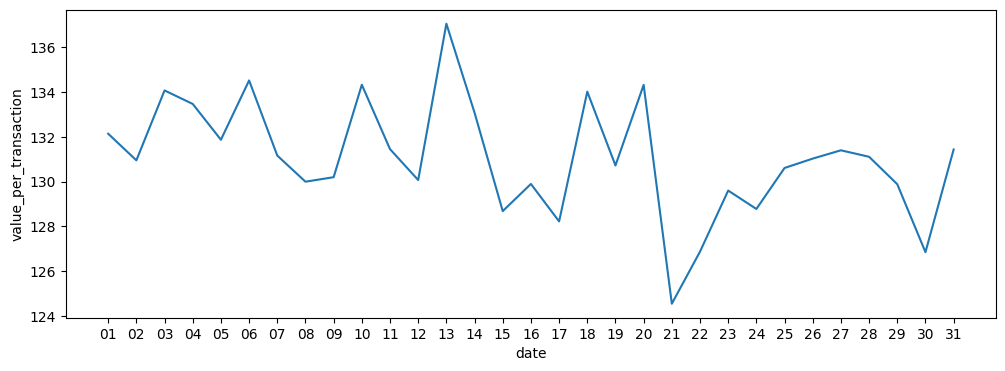

In [80]:
# Plot as a line plot
a4_dims = (12, 4)
data = df_fav_date_to_shop
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax=ax, data=data, x="date", y="value_per_transaction")

<Axes: xlabel='date', ylabel='value_per_transaction'>

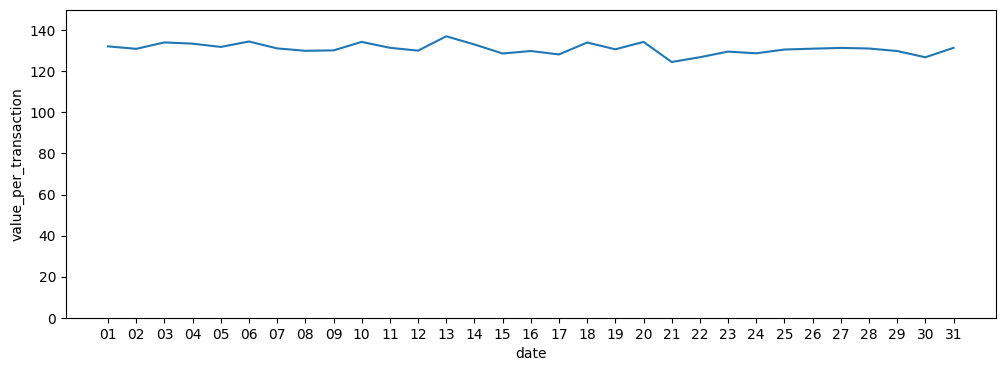

In [81]:
# Plot as a line plot
a4_dims = (12, 4)
data = df_fav_date_to_shop
fig, ax = plt.subplots(figsize=a4_dims)
ax.set(ylim=(0, 150))
sns.lineplot(ax=ax, data=data, x="date", y="value_per_transaction")

### Favorite Day for Shopping

In [147]:
# Find the fav day
query_fav_day_to_shop = """
SELECT
    strftime('%w', o.order_purchase_timestamp) AS weekday_code,
    CASE strftime('%w', o.order_purchase_timestamp)
        WHEN '0' THEN 'Sunday'
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
    END weekday,
    SUM(op.payment_value)/COUNT(o.order_id) AS value_per_transaction,
    COUNT(o.order_id) AS n_of_order
    FROM 
        df_order AS o
    INNER JOIN
        df_order_payments AS op ON o.order_id = op.order_id
    GROUP BY 
        strftime('%w', o.order_purchase_timestamp)
    ORDER BY
        weekday_code ASC
"""


df_fav_day_to_shop = ps.sqldf(query_fav_day_to_shop, locals())
df_fav_day_to_shop

,weekday_code,weekday,value_per_transaction,n_of_order
0,0,Sunday,128.968392,12425
1,1,Monday,131.800329,16875
2,2,Tuesday,131.499754,16695
3,3,Wednesday,131.219029,16274
4,4,Thursday,129.834939,15470
5,5,Friday,131.871570,14768
6,6,Saturday,132.219174,11379


<Axes: xlabel='weekday', ylabel='value_per_transaction'>

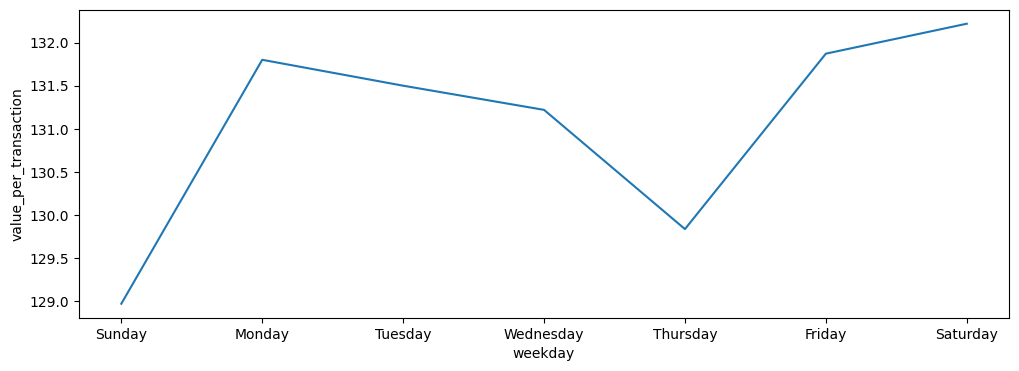

In [148]:
# Plot as a line plot
a4_dims = (12, 4)
data = df_fav_day_to_shop
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax=ax, data=data, x="weekday", y="value_per_transaction")

<Axes: xlabel='weekday', ylabel='value_per_transaction'>

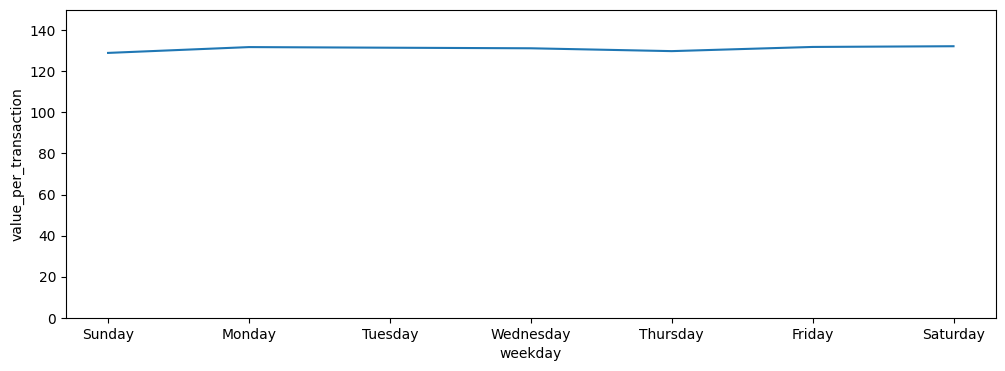

In [149]:
# Plot as a line plot
a4_dims = (12, 4)
data = df_fav_day_to_shop
fig, ax = plt.subplots(figsize=a4_dims)
ax.set(ylim=(0, 150))
sns.lineplot(ax=ax, data=data, x="weekday", y="value_per_transaction")

Text(0, 0.5, '# of Order')

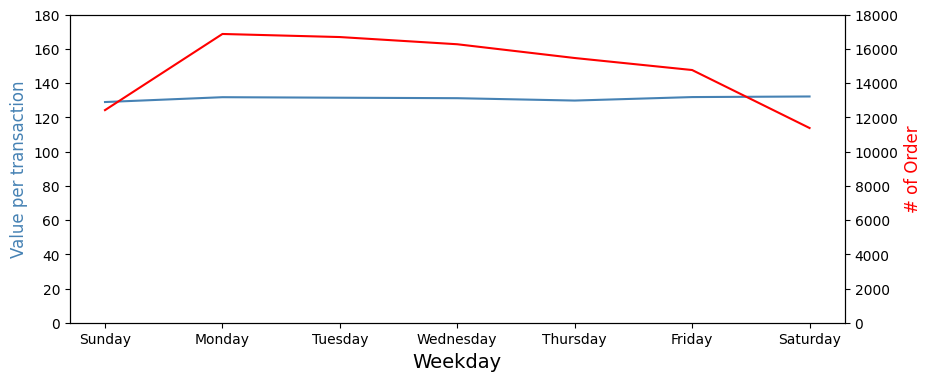

In [176]:
#define the datafram
data = df_fav_day_to_shop

#define colors to use
col1 = 'steelblue'
col2 = 'red'

#define subplots
dims = (10, 4)
fig,ax = plt.subplots(figsize=dims)
ax.set(ylim=(0, 180))

#add first line to plot
ax.plot(data.weekday, data.value_per_transaction, color=col1)

#add x-axis label
ax.set_xlabel('Weekday', fontsize=14)


#add y-axis label
ax.set_ylabel('Value per transaction', color=col1, fontsize=12)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()
ax2.set(ylim=(0, 18000))

#add second line to plot
ax2.plot(data.weekday, data.n_of_order, color=col2)

#add second y-axis label
ax2.set_ylabel('# of Order', color=col2, fontsize=12)

## 6.E. Favorite Payment Method

In [85]:
# Find the fav day
query_fav_payment_method = """
SELECT
    op.payment_type AS payment_method,
    COUNT(o.order_id) AS n_of_order
    FROM 
        df_order AS o
    INNER JOIN
        df_order_payments AS op ON o.order_id = op.order_id
    GROUP BY 
        op.payment_type
    ORDER BY
        n_of_order DESC
"""


df_fav_payment_method = ps.sqldf(query_fav_payment_method, locals())
df_fav_payment_method

,payment_method,n_of_order
0,credit_card,76795
1,boleto,19784
2,voucher,5775
3,debit_card,1529
4,not_defined,3


<Axes: xlabel='n_of_order', ylabel='payment_method'>

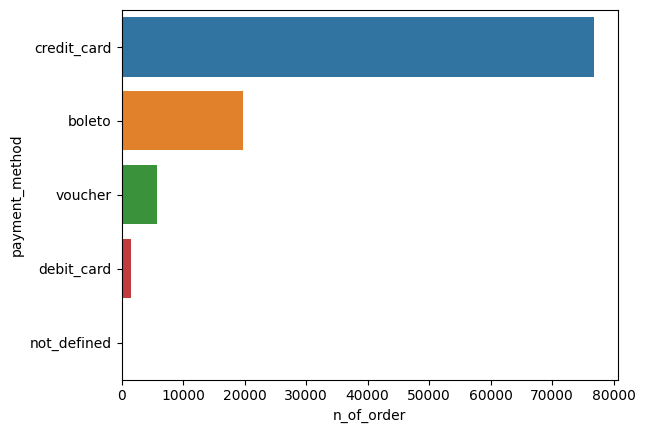

In [86]:
# Plot the query result
sns.barplot(data=df_fav_payment_method, x="n_of_order", y="payment_method")

In [87]:
df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


## 6.F. Product Category with the Highest Average Rating

In [88]:
# Query the table
query_rating_by_prod_cat = """
SELECT
    pcnt.product_category_name_english AS product_category,
    AVG(orv.review_score) AS avg_rating
FROM
    df_order AS o
INNER JOIN
    df_order_reviews AS orv ON o.order_id = orv.order_id
INNER JOIN
    df_order_items AS oi ON o.order_id = oi.order_id
INNER JOIN
    df_products AS p ON oi.product_id = p.product_id
INNER JOIN
    df_product_cat_name_transl AS pcnt ON p.product_category_name = pcnt.product_category_name
GROUP BY product_category
ORDER BY avg_rating DESC
LIMIT 10;
"""

# Define the query result as a dataframe
df_rating_by_prod_cat = ps.sqldf(query_rating_by_prod_cat, locals())
df_rating_by_prod_cat

,product_category,avg_rating
0,cds_dvds_musicals,4.642857
1,fashion_childrens_clothes,4.500000
2,books_general_interest,4.446266
3,costruction_tools_tools,4.444444
4,flowers,4.419355
5,books_imported,4.400000
6,books_technical,4.368421
7,food_drink,4.315412
8,luggage_accessories,4.315257
9,small_appliances_home_oven_and_coffee,4.302632


<Axes: xlabel='avg_rating', ylabel='product_category'>

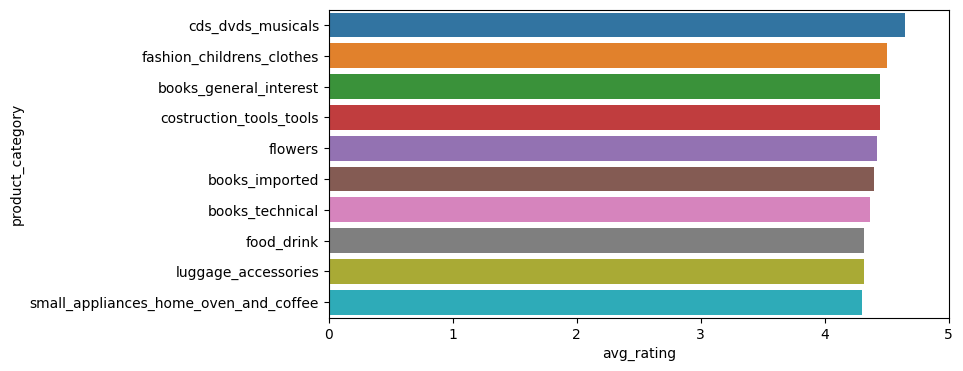

In [89]:
# Plot the query result
dims = (8, 4)
data = df_rating_by_prod_cat
fig, ax = plt.subplots(figsize=dims)
ax.set(xlim=(0, 5))
sns.barplot(data=data, x="avg_rating", y="product_category")

In [90]:
query_products_eng_cat = """
SELECT
    p.product_id AS product_id,
    pcnt.product_category_name_english AS prod_cat,
    p.product_name_lenght AS prod_name_length,
    p.product_photos_qty AS prod_photost_qty,
    p.product_weight_g AS prod_weight_g,
    p.product_length_cm AS prod_length_cm,
    p.product_height_cm AS product_height_cm,
    p.product_width_cm AS product_width_cm
FROM
    df_products AS p
INNER JOIN
    df_product_cat_name_transl AS pcnt ON p.product_category_name = pcnt.product_category_name
"""

df_products_eng_cat = ps.sqldf(query_products_eng_cat, locals())
df_products_eng_cat

,product_id,prod_cat,prod_name_length,prod_photost_qty,prod_weight_g,prod_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,44.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,46.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,27.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...
32933,a0b7d5a992ccda646f2d34e418fff5a0,furniture_decor,45.0,2.0,12300.0,40.0,40.0,40.0
32934,bf4538d88321d0fd4412a93c974510e6,construction_tools_lights,41.0,1.0,1700.0,16.0,19.0,16.0
32935,9a7c6041fa9592d9d9ef6cfe62a71f8c,bed_bath_table,50.0,1.0,1400.0,27.0,7.0,27.0
32936,83808703fc0706a22e264b9d75f04a2e,computers_accessories,60.0,2.0,700.0,31.0,13.0,20.0


## 6.G. Delivery On-Time Performance

In [139]:
query_delivery_perf_by_day = """
SELECT
    o.order_id,
    CASE strftime('%w', o.order_purchase_timestamp)
        WHEN '0' THEN 'Sunday'
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
    END weekday,
    CASE o.order_estimated_delivery_date >= o.order_delivered_customer_date
        WHEN True THEN 'on time'
        WHEN False THEN 'late'
    END is_on_time
FROM
    df_order AS o
"""

df_delivery_perf_by_day = ps.sqldf(query_delivery_perf_by_day, locals())
df_delivery_perf_by_day

,order_id,weekday,is_on_time
0,e481f51cbdc54678b7cc49136f2d6af7,Monday,on time
1,53cdb2fc8bc7dce0b6741e2150273451,Tuesday,on time
2,47770eb9100c2d0c44946d9cf07ec65d,Wednesday,on time
3,949d5b44dbf5de918fe9c16f97b45f8a,Saturday,on time
4,ad21c59c0840e6cb83a9ceb5573f8159,Tuesday,on time
...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,Thursday,on time
99437,63943bddc261676b46f01ca7ac2f7bd8,Tuesday,on time
99438,83c1379a015df1e13d02aae0204711ab,Sunday,on time
99439,11c177c8e97725db2631073c19f07b62,Monday,on time


In [140]:
# Define a function to count percentage
prcntg_of_col_func = lambda x: x*100/sum(x)

# Create a pivot table
df_delivery_perf_by_day_wide = df_delivery_perf_by_day.pivot_table(columns='weekday', index='is_on_time', values='is_on_time',  aggfunc='count').apply(prcntg_of_col_func)
df_delivery_perf_by_day_wide = df_delivery_perf_by_day_wide.reindex(['Sunday', 'Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday'], axis=1)
df_delivery_perf_by_day_wide

weekday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
is_on_time,,,,,,,
late,8.938127,10.576686,9.922947,9.39429,9.017004,10.069395,9.231193
on time,91.061873,89.423314,90.077053,90.60571,90.982996,89.930605,90.768807


In [143]:
query_delivery_perf_by_day = """
SELECT
    CASE o.order_estimated_delivery_date >= o.order_delivered_customer_date
        WHEN True THEN 'on time'
        WHEN False THEN 'late'
    END is_on_time,
    AVG(ore.review_score) AS avg_rating
FROM
    df_order AS o
    INNER JOIN
    df_order_reviews AS ore ON o.order_id = ore.order_id
GROUP BY is_on_time
"""

df_delivery_perf_by_day = ps.sqldf(query_delivery_perf_by_day, locals())
df_delivery_perf_by_day

,is_on_time,avg_rating
0,late,2.420991
1,on time,4.260788


## [Omitted] Customer's First-Time Payment Method

In [90]:
# # Query the table
# query_cust_first_prod_cat = """
# CREATE TEMPORARY TABLE last_viewed_film(SELECT
# 	x.cust_id,
#     x.first_name,
#     x.last_name,
#     x.first_rental_date,
#     x.film_title 
# FROM (SELECT 
#     oc.customer_id AS customer_id,
#     o.purchase_timestamp AS first_purchase_date,
#     pcnt.product_category_name AS product_cat,
#     row_number() OVER (PARTITION BY oc.customer_id ORDER BY o.purchase_timestamp DESC) AS _rn
#         FROM
#         df_order AS o
#         INNER JOIN
#         df_order_customer AS oc ON o.customer_id = oc.customer_id
#         INNER JOIN
#         df_products AS p ON oi.product_id = p.product_id
#         INNER JOIN
#         df_product_cat_name_transl AS pcnt ON p.product_category_name = pcnt.product_category_name
#         ) AS x
# WHERE x._rn = 1);


# SELECT film_title, COUNT(film_title) AS n_order
# FROM last_viewed_film
# GROUP BY film_title
# ORDER BY n_order DESC;
# """

# # Define the query result as a dataframe
# df_cust_first_prod_cat = ps.sqldf(query_cust_first_prod_cat, locals())
# df_cust_first_prod_cat

In [104]:
# # Query the the first_order_id of each customer
# query_cust_first_order = """
# SELECT
#     x.customer_id AS customer_id,
#     x.purchase_date AS first_purchase_date,
#     x.payment_type AS payment_type
# FROM
#     (SELECT 
#         o.customer_id AS customer_id,
#         o.order_purchase_timestamp AS purchase_date,
#         op.payment_type,
#         row_number() OVER (PARTITION BY o.customer_id ORDER BY o.order_purchase_timestamp ASC) AS _rn
#         FROM
#             df_order AS o
#         INNER JOIN
#             df_order_payments AS op ON o.order_id = op.order_id) x
# WHERE x._rn = 1;
# """

# # Define the query result as a dataframe
# df_cust_first_order = ps.sqldf(query_cust_first_order, locals())
# df_cust_first_order

,customer_id,first_purchase_date,payment_type
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26.000000,credit_card
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32.000000,credit_card
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43.000000,credit_card
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20.000000,boleto
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17.000000,boleto
...,...,...,...
99435,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26.000000,credit_card
99436,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02.000000,credit_card
99437,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05.000000,credit_card
99438,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32.000000,credit_card
